In [1]:
import numpy as np
import nltk
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import heapq

In [2]:
#intialization
N=1000
alpha_diag=[]
iteration_diagonal=[1]
word_count = {}
l=[]
sigma_diag=[]
mean_diag=[]



In [3]:
#reading a file 
f=open('data_file.txt',"r")      
#contents is a list with each elements as a line of the text
txt=f.readlines()
size=len(txt)

#removing End Labels 
p=0
while p<size:
    l.append((int)(txt[p][len(txt[p])-2]))   #appending the label
    v=len(txt[p])-2
    txt[p]=txt[p][:v]
    p+=1

In [4]:
#function to perform expectation step in EM algorithm

def Expectation(data_array_transposed,alpha_list,cov_list,mu_li):
    j=len(alpha_list)
    n=data_array_transposed.shape[1]
    weighted_normal=[]
    l=0
    for i in range(n):
        for k in range(j):
            mean=mu_li[k]
            cov=cov_list[k]
            var_1=multivariate_normal.pdf(data_array_transposed[:,i],mean,cov)
            weighted_normal.append(alpha_list[k]* var_1)
        a=np.array(weighted_normal)
        l=np.log(np.sum(a))
        weighted_normal=[]
        l=l+1
    return l

#function to perform maximization step in EM algorithm


def maximization(data_tr,alpha_list,cov_list,mu_li):
    n=data_tr.shape[1]
    m=data_tr.shape[0]
    j=len(alpha_list)
    gama=np.zeros((n,j))
    weighted_normal=np.zeros((n,j))
    m=data_tr.shape[0]
    
    
    for i in range(n):
        for k in range(j):
            va_1=multivariate_normal.pdf(data_tr[:,i],mean=mu_li[k],cov=cov_list[k])
            va_2=va_1
            x=alpha_list[k]* va_2
            weighted_normal[i,k]=x
    dinominator=np.sum(weighted_normal,axis=1) 
    for i in range(n):
        for k in range(j):
            gama[i,k]=weighted_normal[i,k]
            gama[i,k]=gama[i,k]/dinominator[i]
    mean_deviation_dinomintor=np.sum(gama,axis=0)
    alpha=mean_deviation_dinomintor/n
    #updated weights
    alpha_list_updated=alpha.tolist()
    
#calculating mean
    sum_mean=[]
    for k in range(j):
        e=np.zeros(m)
        e1=np.zeros(m)
        for i in range(n):
            v=(float)(gama[i,k])
            shape=data_tr[0:m,i].shape
            if e.shape==shape:
                
                e=e+v*data_tr[:,i]
                
        sum_mean.append(e)
    mean_sum=np.array(sum_mean)
    mean_new=[]
    for k in range(j):
        mean_new.append(mean_sum[k]/mean_deviation_dinomintor[k])
    
#NOW CALCULATING SIGMA 
    sum_mean1=[]
    for k in range(j):
        e=np.zeros([m,m])
        for i in range(n):
            v=(float)(gama[i,k])
            
                
            e=e+v*np.outer(data_tr[:,i]-mean_new[k],data_tr[:,i]-mean_new[k])
            
        sum_mean1.append(e)
    sd_new=[]
    mean_sum1=np.array(sum_mean1)
    for k in range(j):
        p1=mean_sum1[k]/mean_deviation_dinomintor[k]
        sd_new.append(np.diag(np.diag(p1)))

        
            
           
    return sd_new,mean_new,alpha_list_updated

In [5]:
def classification(sigma,data,mu):
    n=data.shape[0]
    data_transposed=np.transpose(data)
    data_0=[]
    data_1=[]
    for i in range(n):
        mean1=mu[0]
        mean2=mu[1]
        cov1=sigma[0]
        cov2=sigma[1]
        w0=multivariate_normal.pdf(data_transposed[:,i],mean1,cov1)
        l3=np.log(w0)
        w1=multivariate_normal.pdf(data_transposed[:,i],mean2,cov2)
        l4=np.log(w1)
        if l3>=l4:
            data_0.append(data_transposed[:,i])
        else:
            data_1.append(data_transposed[:,i])
    
    return data_0,data_1



def pca(data,k):
    data_trans=np.transpose(data)
    cov_data=np.cov(data_trans)
    eig_val,eig_vector=np.linalg.eig(cov_data)
    #eig_vals,eig_vectors=eigen_sort(eig_val,eig_vector)
    id_val = eig_val.argsort()[::-1]   
    eigenValues = eig_val[id_val]
    eigenVectors = eig_vector[:,id_val]
    
    u=eigenVectors[:,:k]
    y=np.matmul(data,u)
    return y


def ClusterIndex(clustNum, labels_array):  
    return np.where(labels_array == clustNum)[0]


In [6]:
def plot(sig,mu,data_trans,j):
    d1=[]
    d2=[]
    plt.figure()
    for i in range(1000):
        mean1=mu[0]
        mean2=mu[1]
        w1=multivariate_normal.pdf(data_trans[:,i],mean1,cov=sig[0])
        l1=np.log(w1)
        w2=multivariate_normal.pdf(data_trans[:,i],mean2,cov=sig[1])
        l2=np.log(w2)
        
        if l1>=l2:
            d1.append(data_trans[:,i])
        else:
            d2.append(data_trans[:,i])
    s="EM Iteration ="+str(j)
    data_1=np.array(d1)
    data_2=np.array(d2)
    plt.scatter(data_1[:,0],data_1[:,1],c='c',marker='x',label=s)
    plt.scatter(data_2[:,0],data_2[:,1],c='m',marker='x',label=s)
    plt.scatter(mu[0][0],mu[0][1],c='k',marker='D',label="Mean(Blue Dots)",s=120)
    plt.scatter(mu[1][0],mu[1][1],c='y',marker='D',label="Mean(Purple Dots)",s=120)
    
    plt.legend(loc='upper right')

<ipython-input-6-c77f6904a7aa>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


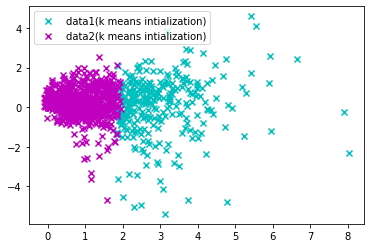

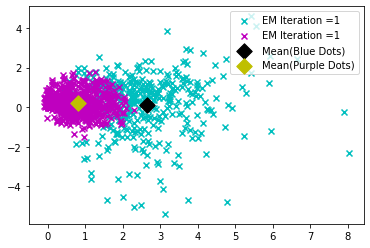

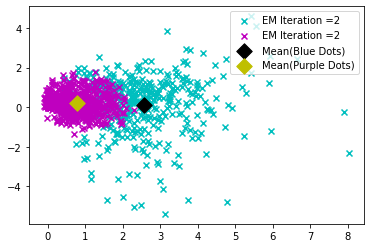

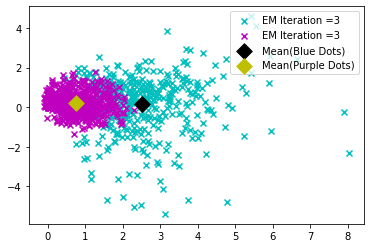

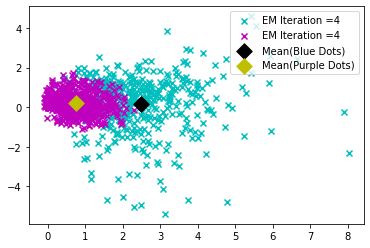

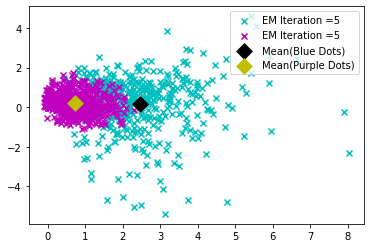

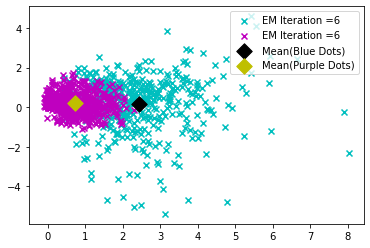

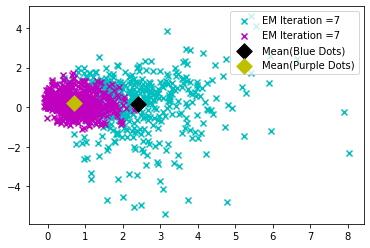

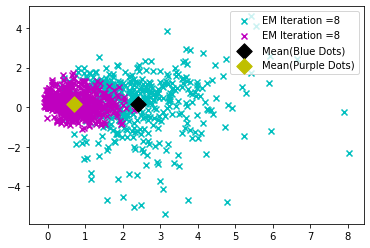

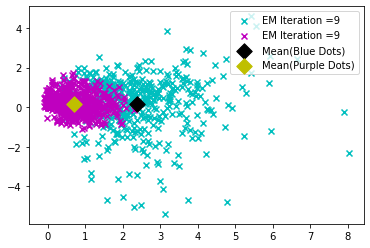

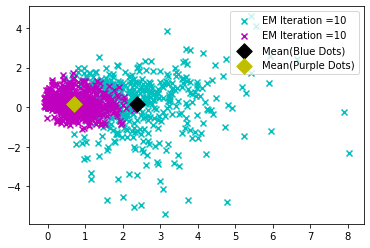

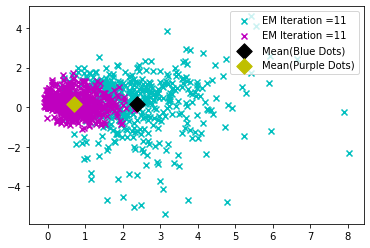

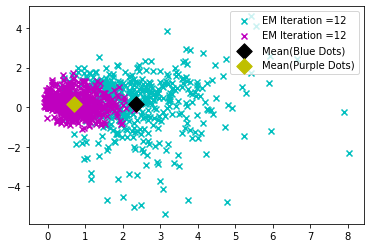

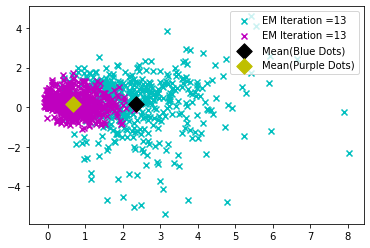

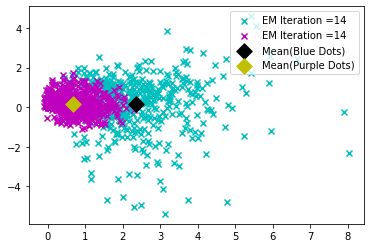

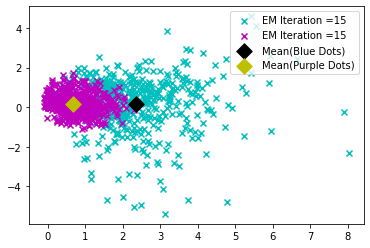

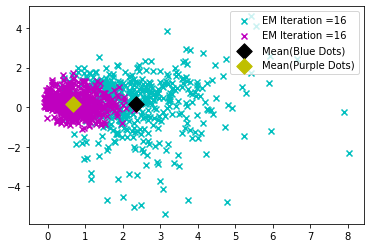

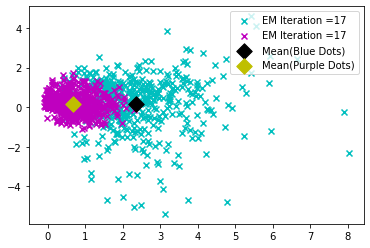

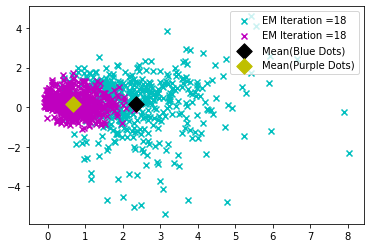

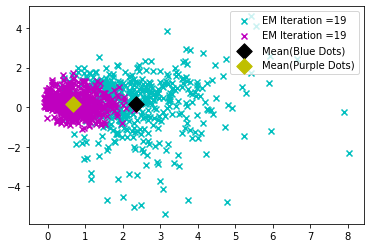

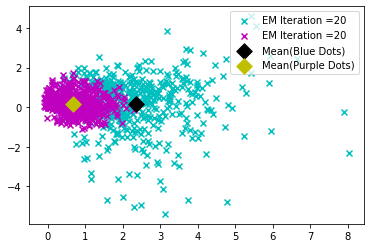

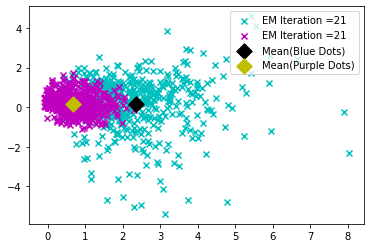

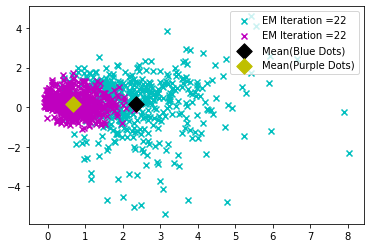

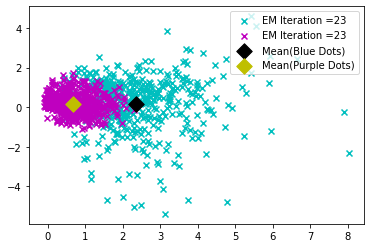

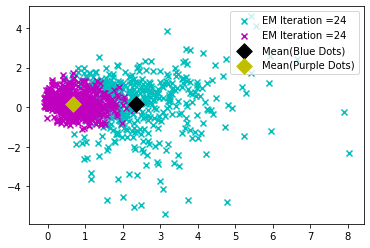

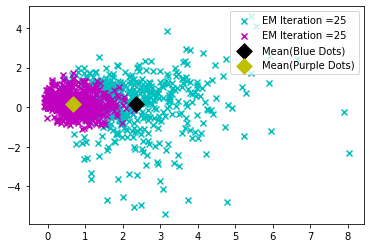

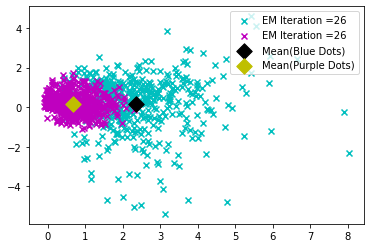

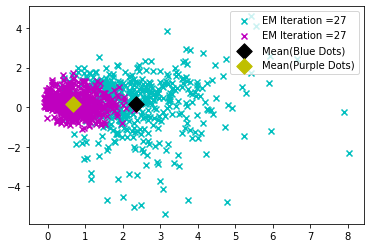

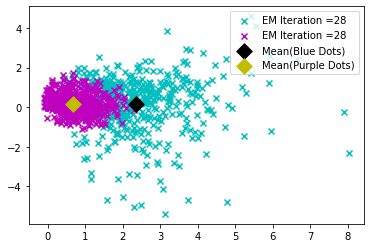

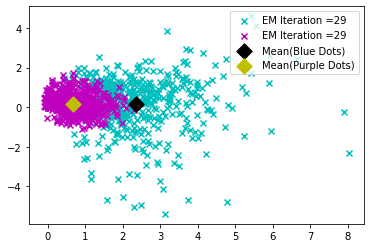

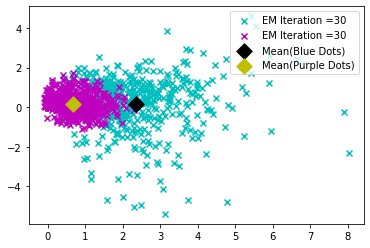

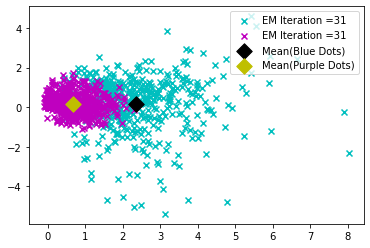

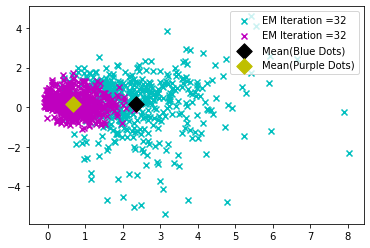

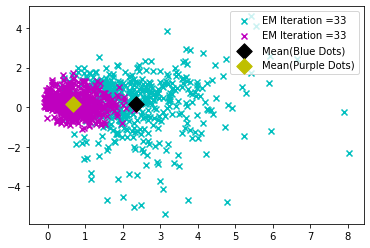

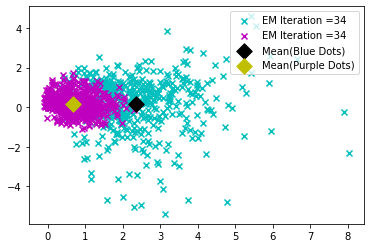

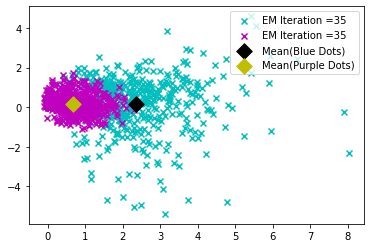

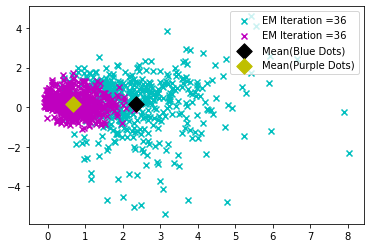

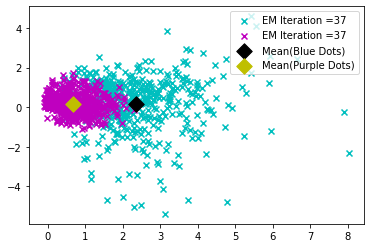

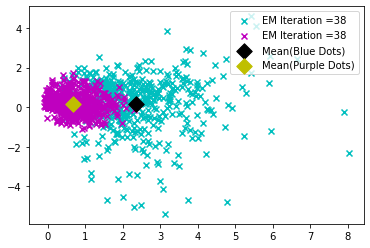

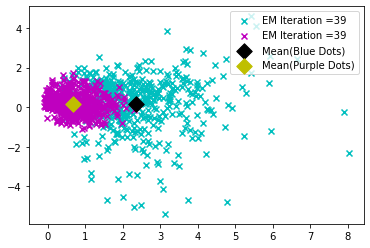

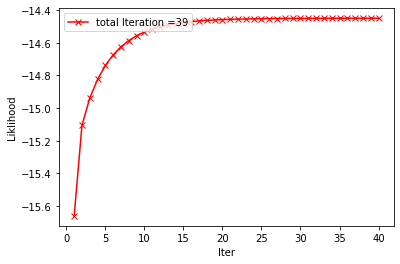

The classification Accuracy is 51.8%


In [7]:
cnt=0
sent_vect = []
for line in txt:
    token_list = nltk.word_tokenize(line)
    for token in token_list:
        cnt+=1
        if token not in word_count.keys():
            word_count[token] = 1
        else:
            word_count[token] += 1
            
most_freq = heapq.nlargest(3000, word_count, key=word_count.get)  #finding top frequency words using max heap

for line in txt:
    line_tokens = nltk.word_tokenize(line)
    sent_vec = []
    for token in most_freq:
        if token in line_tokens:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    sent_vect.append(sent_vec)
    


#tf ifd n=total number of documents
 
feture=np.zeros([1000,200])
sent_vect = np.asarray(sent_vect)
df=np.sum(sent_vect,axis=0)
for i in range(N):
    for j in range(200):
        
        val=np.log(N/df[j])
        feture[i,j]=(float)(sent_vect[i,j] *val)
                
featue_updated=pca(feture,10)


#now applying GMM for 2 clusters 
kmeans = KMeans(n_clusters=2, random_state=0).fit(featue_updated)
labels=kmeans.labels_
cluster_centers=kmeans.cluster_centers_


mean1=cluster_centers[0,:]
mean2=cluster_centers[1,:]
s1=mean1
s2=mean2

d1=featue_updated[ClusterIndex(0,kmeans.labels_)]
data1=np.transpose(d1)
d2=featue_updated[ClusterIndex(1,kmeans.labels_)]
data2=np.transpose(d2)
l=np.array(l)
mean_list=[mean1,mean2]

data_t1=np.transpose(featue_updated[ClusterIndex(0,l)])
data_t2=np.transpose(featue_updated[ClusterIndex(1,l)])

data1=(np.array(data1))
data2=(np.array(data2))

#plotting our data points . intialized to specific clusters
plt.figure()
plt.scatter(data1[0,:],data1[1,:],c='c',label='data1(k means intialization)',marker='x')
plt.scatter(data2[0,:],data2[1,:],c='m',label='data2(k means intialization)',marker='x')
plt.legend(loc='upper left')
cov1=np.cov(data1)
cov2=np.cov(data2)
cov_list=[cov1,cov2]

data_t1=np.transpose(data_t1)
data_t2=np.transpose(data_t2)

a1=data1.shape[1]/featue_updated.shape[0]
a2=-1 *(a1-1)


cov1d=np.diag(np.diag(cov1))
cov2d=np.diag(np.diag(cov2))
al_list=[a1,a2]
covd_list=[cov1d,cov2d]
l_in=Expectation(np.transpose(featue_updated),al_list,covd_list,mean_list)

    
feature_trans=np.transpose(featue_updated)
sd_updated,mean_updated,al_list_updated1=maximization(feature_trans,al_list,covd_list,mean_list)
likli_diag=[l_in]

#now here we will train the data
i=1
while(True):
    ch1=0
    Feature_T=np.transpose(featue_updated)
    sd_updated,mean_updated,al_list_updated1=maximization(Feature_T,al_list_updated1,sd_updated,mean_updated)
    X_1=np.transpose(featue_updated)
    L1=Expectation(X_1,al_list_updated1,sd_updated,mean_updated)
    likli_diag.append(L1)
    feature_1=np.transpose(featue_updated)
    plot(sd_updated,mean_updated,feature_1,i)
    i=i+1
    diff=(likli_diag[i-1]-likli_diag[i-2])
    iteration_diagonal.append(i)
    s="total Iteration ="+str(i-1)
    if i>=30:
        for x in range(i,i-25,-1):
            diff1=(likli_diag[x-1]-likli_diag[x-2])
            if diff1<=1:
                ch1=ch1+1
        if ch1==24:
            sigma_diag=sd_updated
            mean_diag=mean_updated
            alpha_diag=al_list_updated1
            break
        else:
            ch1=0
    if i>=40:                         #convergence condition
        sigma_diag=sd_updated
        mean_diag=mean_updated
        alpha_diag=al_list_updated1
        break



plt.figure()

plt.plot(iteration_diagonal,likli_diag,marker='x',c='r',label=s)
plt.ylabel("Liklihood")
plt.xlabel("Iter")

plt.legend(loc='upper left')

plt.show()

#classification
class_1,class_2=classification(sd_updated,data_t1,mean_updated)
k_1,k_2=classification(sd_updated,data_t2,mean_updated)
incorrect_c1=len(class_1)
incorrect_k2=len(k_2)
miss=(incorrect_c1+incorrect_k2)/10
accur=100-miss
print("The classification Accuracy is {}%".format (accur))
